# Q1. Is the top ad position the best performing spot in terms of click-through rate?

In [1]:
import pandas as pd

file_path = './ad_click_dataset.csv'
df = pd.read_csv(file_path)

In [42]:
df

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
2,7993,User7993,NaN,Non-Binary,Mobile,Bottom,Social Media,NaN,1
3,2595,User2595,NaN,NaN,NaN,Bottom,NaN,Morning,1
4,8171,User8171,NaN,Non-Binary,Mobile,Side,Education,Afternoon,0
...,...,...,...,...,...,...,...,...,...
4995,8994,User8994,34.0,NaN,Mobile,Bottom,Entertainment,Morning,1
4996,7518,User7518,NaN,NaN,Desktop,Bottom,News,Evening,1
4997,503,User503,43.0,NaN,NaN,NaN,NaN,Morning,1
4998,7843,User7843,NaN,Female,Desktop,Bottom,Entertainment,NaN,0


In [2]:
# Distribution Analysis
# First let's see the total distribution including NaN
print("Distribution of ad positions including NaN:")
position_counts = (df['ad_position']
                  .value_counts(dropna=False)
                  .to_frame('Count')
                  .assign(Percentage = lambda x: round(x['Count'] / len(df) * 100, 2))
                 )
# Format percentage for display
position_counts['Percentage'] = position_counts['Percentage'].astype(str) + '%'
position_counts


Distribution of ad positions including NaN:


,Count,Percentage
ad_position,,
Bottom,2817,28.17%
Top,2597,25.97%
Side,2586,25.86%
NaN,2000,20.0%


In [17]:
# CTR Analysis without duplicate columns
ctr_by_position = (df
    .groupby('ad_position', dropna=False)
    .agg({
        'click': ['count', 'sum', 'mean']
    })
    .pipe(lambda x: x.set_axis(['Impressions', 'Clicks', 'CTR'], axis=1))
    .assign(
        CTR_pct=lambda x: (x['CTR'] * 100).round(2)  # Numeric column for plotting
    )
    .assign(
        CTR=lambda x: x['CTR_pct'].astype(str) + '%'  # Format CTR as percentage
    )
    .drop('CTR_pct', axis=1)  # Remove the temporary numeric column after plotting
)

print("\nCTR Analysis by Position (including NaN):")
ctr_by_position



CTR Analysis by Position (including NaN):


,Impressions,Clicks,CTR
ad_position,,,
Bottom,2817,1936,68.73%
Side,2586,1633,63.15%
Top,2597,1649,63.5%
NaN,2000,1282,64.1%


/var/folders/gj/dlpt7v155_v5zft2lgdt3y1w0000gn/T/ipykernel_22988/1459156712.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


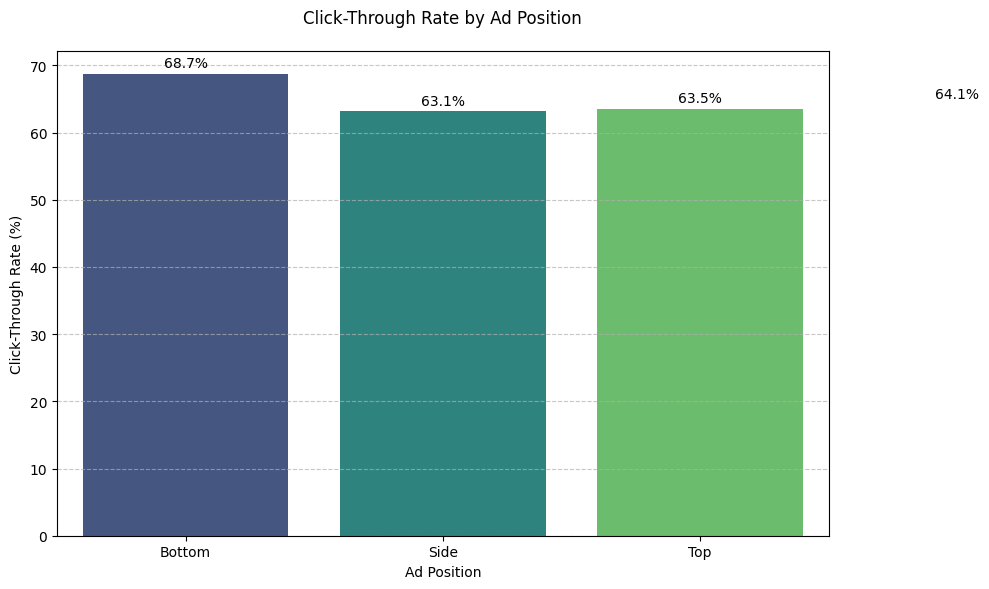

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# For plotting, we'll need the CTR values as numbers, so let's create a temporary column just for plotting
plot_data = ctr_by_position.assign(
    CTR_pct=lambda x: x['CTR'].str.rstrip('%').astype(float)
    )

# Create visualization
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=plot_data.index, 
    y='CTR_pct', 
    data=plot_data, 
    palette='viridis'
)

# Add value labels on top of bars
for i, v in enumerate(plot_data['CTR_pct']):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center')

# Customize the plot
plt.title('Click-Through Rate by Ad Position', pad=20)
plt.xlabel('Ad Position')
plt.ylabel('Click-Through Rate (%)')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Marketing team's belief that the top ad position performs best in terms of click through rates does not seem to be supported by data without NA's. 

Let's determine if I am missing something with rows with missing position by examining if there's pattern. 

In [19]:
# 1. First, let's check if missing ad positions are related to other variables
# Create a binary column for missing ad_position
df['is_missing_position'] = df['ad_position'].isna()

# Check relationship with other variables
print("Pattern Analysis of Missing Values:")
print("\n1. Relationship with device_type:")
print(pd.crosstab(df['is_missing_position'], df['device_type'], normalize='index'))

print("\n2. Relationship with time_of_day:")
print(pd.crosstab(df['is_missing_position'], df['time_of_day'], normalize='index'))

print("\n3. Relationship with gender:")
print(pd.crosstab(df['is_missing_position'], df['gender'], normalize='index'))

print("\n4. Click rates comparison:")
print("CTR for records with missing position:", 
      df[df['is_missing_position']]['click'].mean())
print("CTR for records with known position:",
      df[~df['is_missing_position']]['click'].mean())


Pattern Analysis of Missing Values:

1. Relationship with device_type:
device_type           Desktop    Mobile    Tablet
is_missing_position                              
False                0.345717  0.331261  0.323022
True                 0.338226  0.330568  0.331206

2. Relationship with time_of_day:
time_of_day          Afternoon   Evening   Morning     Night
is_missing_position                                         
False                 0.248908  0.248283  0.261548  0.241261
True                  0.264447  0.230528  0.282663  0.222362

3. Relationship with gender:
gender                 Female      Male  Non-Binary
is_missing_position                                
False                0.351102  0.336887    0.312011
True                 0.324125  0.357274    0.318600

4. Click rates comparison:
CTR for records with missing position: 0.641
CTR for records with known position: 0.65225


So excluding missing position seems reasonable (to answer Marketing team's question of best performing ad position) because
  - the distributions across key variables are fairly similar
  - CTR difference is minimal
  - Missing patterns appear to be mostly random

From CTR point of view, bottom performs the best but is this statistically significant? 
There are statistical tests applicable: 
  - t-test
  - chi-square test

T-test Requirements:
- Assumes normal distribution
- Continuous data
- Independent observations

Chi-square Test Requirements:
- Categorical data (which we have)
- Independent observations
- No assumption about distribution

Our Data:
- CTR is binary (click/no-click)
- Not normally distributed by nature (it's binary)

In [21]:
from scipy.stats import chi2_contingency

# Create contingency table
contingency = pd.crosstab(df['ad_position'], df['click'])

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency)

print("Contingency Table:")
print(contingency)
print("\nChi-square test results:")
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")

# If you want to see which positions are significantly different,
# you can run pairwise comparisons
positions = df['ad_position'].unique()
print("\nPairwise comparisons:")
for i in range(len(positions)):
    for j in range(i+1, len(positions)):
        pos1, pos2 = positions[i], positions[j]
        subset = df[df['ad_position'].isin([pos1, pos2])]
        cont_table = pd.crosstab(subset['ad_position'], subset['click'])
        chi2, p_value, _, _ = chi2_contingency(cont_table)
        print(f"{pos1} vs {pos2}:")
        print(f"Chi-square: {chi2:.2f}, p-value: {p_value:.4f}")

Contingency Table:
click          0     1
ad_position           
Bottom       881  1936
Side         953  1633
Top          948  1649

Chi-square test results:
Chi-square statistic: 23.56
p-value: 0.0000
Degrees of freedom: 2

Pairwise comparisons:
Top vs Side:
Chi-square: 0.05, p-value: 0.8169
Top vs nan:
Chi-square: 0.00, p-value: 1.0000
Top vs Bottom:
Chi-square: 16.28, p-value: 0.0001
Side vs nan:
Chi-square: 0.00, p-value: 1.0000
Side vs Bottom:
Chi-square: 18.46, p-value: 0.0000
nan vs Bottom:
Chi-square: 0.00, p-value: 1.0000


Overall Chi-square Test:
Chi-square statistic: 23.56
p-value: 0.0000 (< 0.05)
This indicates there is a statistically significant relationship between ad position and click rates. In other words, ad position does affect CTR
Bottom position performs significantly better than both Top and Side
There's no significant difference between Top and Side positions
The marketing team's belief about Top position performing best is incorrect

null hypothesis is that there is no relationship between ad position and click through rate. Mathematically speaking, P(click | position=Top) = P(click | position=Bottom) = P(click | position=Side)

Extremely low p-value means we reject the null hypothesis. Ad position and CTR are not independent. 

Top vs Side:     p-value: 0.8169 (not significant)
Top vs Bottom:   p-value: 0.0001 (significant)
Side vs Bottom:  p-value: 0.0000 (significant)

So not only are we refuting the null hypothesis that all positions perform the same, but we can specifically say:
Bottom performs differently (better) than both Top and Side
Top and Side perform similarly to each other


# Q2
Use a statistical test and a visualisation that illustrates the difference in the “time of day” variable and the age distribution of participants who see our ads.


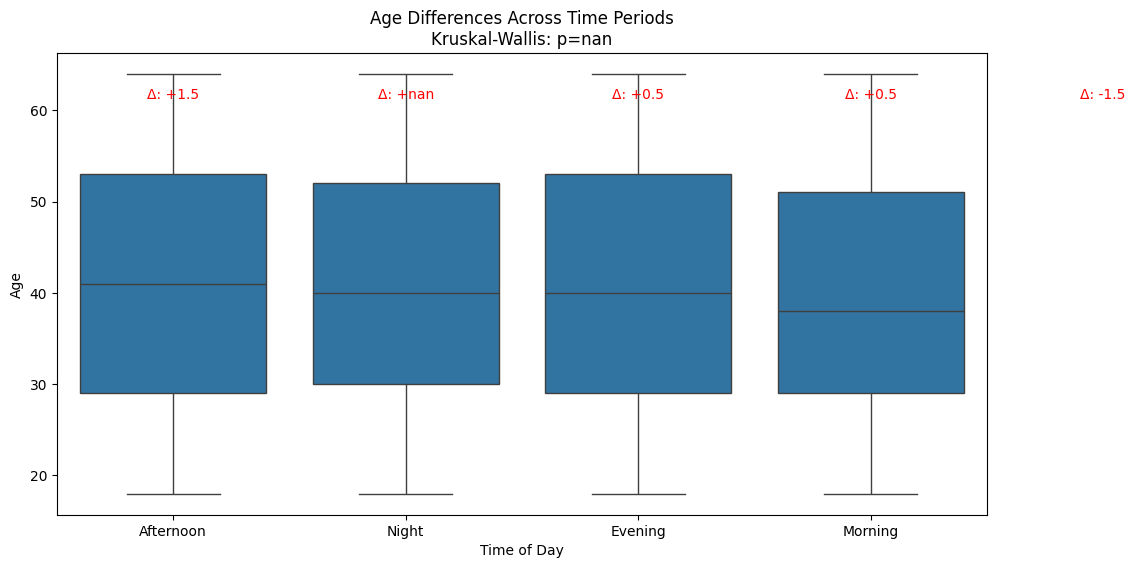

In [35]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Read the data
df = pd.read_csv('ad_click_dataset.csv')

# Clean the data
df_clean = df.dropna(subset=['age', 'time_of_day'])

# Create visualization focusing on DIFFERENCES
plt.figure(figsize=(12, 6))

# Box plot with statistical annotations
sns.boxplot(x='time_of_day', y='age', data=df)

# Add statistical test results
h_stat, p_value = stats.kruskal(*[group['age'].values 
                                 for name, group in df.groupby('time_of_day')])

# Add annotations
plt.title(f'Age Differences Across Time Periods\nKruskal-Wallis: p={p_value:.4f}')
plt.xlabel('Time of Day')
plt.ylabel('Age')

# Add median differences
for i, time in enumerate(df['time_of_day'].unique()):
    subset = df[df['time_of_day'] == time]['age']
    median = subset.median()
    overall_median = df['age'].median()
    diff = median - overall_median
    plt.text(i, plt.ylim()[1]-5, f'Δ: {diff:+.1f}', 
             horizontalalignment='center', color='red')

plt.show()

In [36]:

# Perform Kruskal-Wallis test
grouped_data = [group['age'].values 
               for name, group in df_clean.groupby('time_of_day')]
h_stat, p_value = stats.kruskal(*grouped_data)

print("\nStatistical Analysis:")
print("-" * 50)
print("Kruskal-Wallis Test Results:")
print(f"H-statistic: {h_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Significant differences: {'Yes' if p_value < 0.05 else 'No'}")

# Summary statistics
print("\nSummary Statistics by Time of Day:")
print("-" * 50)
summary_stats = df_clean.groupby('time_of_day')['age'].agg([
    'count',
    'mean',
    'median',
    'std'
]).round(2)

print(summary_stats)

# If significant, show pairwise comparisons
if p_value < 0.05:
    print("\nSignificant Pairwise Comparisons:")
    print("-" * 50)
    times = sorted(df_clean['time_of_day'].unique())
    for i in range(len(times)):
        for j in range(i+1, len(times)):
            time1_ages = df_clean[df_clean['time_of_day'] == times[i]]['age']
            time2_ages = df_clean[df_clean['time_of_day'] == times[j]]['age']
            stat, p = stats.mannwhitneyu(time1_ages, time2_ages)
            if p < 0.05:
                print(f"{times[i]} vs {times[j]}: p-value = {p:.4f}")


Statistical Analysis:
--------------------------------------------------
Kruskal-Wallis Test Results:
H-statistic: 10.4156
p-value: 0.0153
Significant differences: Yes

Summary Statistics by Time of Day:
--------------------------------------------------
             count   mean  median    std
time_of_day                             
Afternoon     1022  41.17    41.0  13.41
Evening        985  40.71    40.0  13.03
Morning       1144  39.48    38.0  12.97
Night         1040  39.83    40.0  12.89

Significant Pairwise Comparisons:
--------------------------------------------------
Afternoon vs Morning: p-value = 0.0045
Afternoon vs Night: p-value = 0.0308
Evening vs Morning: p-value = 0.0368


From these results, we can draw several important conclusions:

1. **Overall Statistical Significance**:
   - The Kruskal-Wallis test shows a significant difference (p = 0.0153 < 0.05)
   - This means there are meaningful differences in age distributions across different times of day
   - H-statistic of 10.4156 indicates moderate strength in these differences

2. **Specific Time Period Differences**:
   Significant pairwise comparisons show:
   - Afternoon (median = 41.0) vs Morning (median = 38.0), p = 0.0045
     * Strongest difference with lowest p-value
     * Afternoon viewers are typically older
   - Afternoon (median = 41.0) vs Night (median = 40.0), p = 0.0308
     * Moderate difference
   - Evening (median = 40.0) vs Morning (median = 38.0), p = 0.0368
     * Morning has notably younger viewers

3. **Pattern Analysis**:
   - Morning has youngest audience (mean = 39.48, median = 38.0)
   - Afternoon has oldest audience (mean = 41.17, median = 41.0)
   - Evening and Night fall in between
   - Standard deviations are similar (~13 years) across all times

4. **Practical Implications**:
   - Age targeting could be optimized by time of day
   - Morning ads could target younger audiences
   - Afternoon/Evening ads might be better for older audiences
   - The differences, while statistically significant, are relatively small (2-3 years) in practical terms

5. **Why This Matters**:
   - Helps inform ad targeting strategies
   - Could influence content and creative decisions
   - Allows for more precise audience segmentation
   - Enables time-based optimization of campaigns

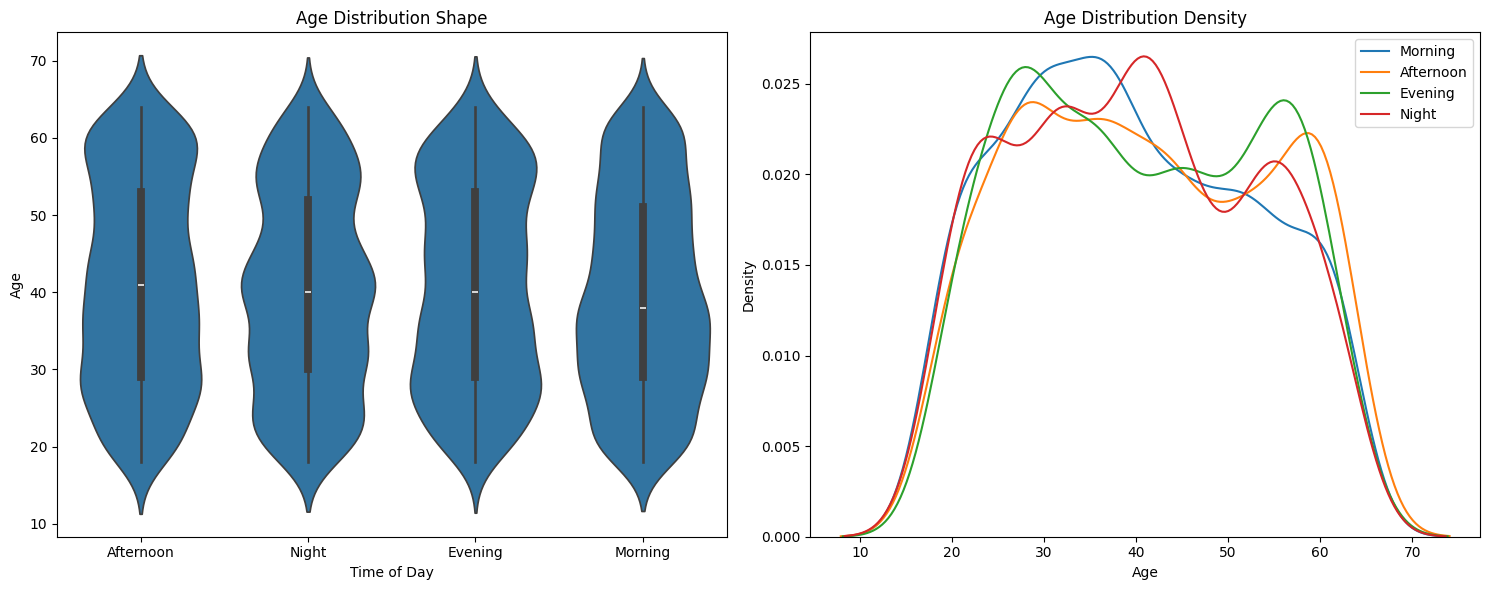


Distribution Characteristics by Time of Day:
--------------------------------------------------

Morning:
Mode: 36.0
Skewness: 0.176
Kurtosis: -1.082

Afternoon:
Mode: 29.0
Skewness: 0.060
Kurtosis: -1.219

Evening:
Mode: 26.0
Skewness: 0.063
Kurtosis: -1.261

Night:
Mode: 32.0
Skewness: 0.094
Kurtosis: -1.104


In [39]:
# Create figure with two complementary distribution plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Clean the data - remove rows with NaN values
df_clean = df.dropna(subset=['age', 'time_of_day'])

# 1. Violin plot showing distribution shape
sns.violinplot(x='time_of_day', y='age', data=df_clean, ax=ax1)
ax1.set_title('Age Distribution Shape')
ax1.set_xlabel('Time of Day')
ax1.set_ylabel('Age')

# 2. KDE plot showing density overlap
times = ['Morning', 'Afternoon', 'Evening', 'Night']  # Define order explicitly
for time in times:
    subset = df_clean[df_clean['time_of_day'] == time]['age']
    sns.kdeplot(data=subset, label=time, ax=ax2)
ax2.set_title('Age Distribution Density')
ax2.set_xlabel('Age')
ax2.set_ylabel('Density')
ax2.legend()

plt.tight_layout()
plt.show()

# Print distribution characteristics
print("\nDistribution Characteristics by Time of Day:")
print("-" * 50)
for time in times:  # Use the same defined order
    subset = df_clean[df_clean['time_of_day'] == time]['age']
    print(f"\n{time}:")
    print(f"Mode: {subset.mode().iloc[0]:.1f}")
    print(f"Skewness: {subset.skew():.3f}")
    print(f"Kurtosis: {stats.kurtosis(subset.dropna()):.3f}")


5. What strategies can you use to handle missing data in this dataset? Implement one strategy that revolves around imputation with pandas.

Let's analyze these findings:

1. Device Type Distribution:
- Very similar distribution between missing and non-missing positions
- Desktop: 34.57% (known) vs 33.82% (missing)
- Mobile: 33.13% (known) vs 33.06% (missing)
- Tablet: 32.30% (known) vs 33.12% (missing)
- Conclusion: Missing values appear to be randomly distributed across devices

2. Time of Day Pattern:
- Slight variations but no dramatic differences
- Morning shows slightly higher missing values (28.27% vs 26.15%)
- Night shows slightly lower missing values (22.24% vs 24.13%)
- Conclusion: Some minor temporal patterns but not strongly biased

3. Gender Distribution:
- Small differences:
- Female: Lower in missing (32.41%) vs known (35.11%)
- Male: Higher in missing (35.73%) vs known (33.69%)
- Non-Binary: Similar (31.86% vs 31.20%)
- Conclusion: Slight gender-based variations but not dramatic

4. Click-Through Rate Comparison:
- Missing positions: 64.10% CTR
- Known positions: 65.23% CTR
- Difference is relatively small (about 1.13 percentage points)
- Conclusion: Missing values don't substantially impact click behavior

Overall Recommendations:

1. Given that:
   - The distributions across key variables are fairly similar
   - CTR difference is minimal
   - Missing patterns appear to be mostly random (MCAR - Missing Completely At Random)

2. We have three valid approaches:
   a) Complete Case Analysis: 
      - Drop missing values since they appear random and CTR is similar
      - This would be valid for answering the marketing team's question
   
   b) Treat as Separate Category:
      - Include "Unknown Position" as a fourth category
      - This maintains data transparency
   
   c) Imputation:
      - Less necessary given the random nature of missing data
      - Could still be done using device_type and time_of_day if needed

Recommendation for Marketing Team Question:
1. Use Complete Case Analysis since:
   - Missing data appears random
   - CTR patterns are similar
   - It simplifies the analysis without introducing bias

# 4. 
Create one visualisation to show which device type is the most effective; choose the best applicable definition of effective for this task, but explain why you chose this definitio


In [41]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Define function to calculate device metrics
def calculate_device_metrics(df):
    metrics = []
    
    for device in df['device_type'].dropna().unique():
        device_data = df[df['device_type'] == device]
        
        # Basic counts
        impressions = len(device_data)
        clicks = device_data['click'].sum()
        conversions = device_data[
            (device_data['click'] == 1) & 
            (device_data['conversion_value'] > 0)
        ].shape[0]
        
        # Revenue metrics
        conversion_value = device_data[
            (device_data['click'] == 1) & 
            (device_data['conversion_value'] > 0)
        ]['conversion_value'].mean()
        
        # Calculate rates
        ctr = (clicks / impressions * 100) if impressions > 0 else 0
        conversion_rate = (conversions / clicks * 100) if clicks > 0 else 0
        
        metrics.append({
            'device_type': device,
            'impressions': impressions,
            'clicks': clicks,
            'ctr': ctr,
            'conversion_rate': conversion_rate,
            'avg_conversion_value': conversion_value if not pd.isna(conversion_value) else 0
        })
    
    return pd.DataFrame(metrics)

# Calculate metrics
device_metrics = calculate_device_metrics(df)

# Create visualization
plt.figure(figsize=(12, 6))

# Set up the bar plot
bar_width = 0.25
x = range(len(device_metrics['device_type']))

# Plot CTR
plt.bar([i - bar_width for i in x], 
        device_metrics['ctr'], 
        bar_width, 
        label='CTR (%)', 
        color='skyblue')

# Plot Conversion Rate
plt.bar([i for i in x], 
        device_metrics['conversion_rate'], 
        bar_width, 
        label='Conversion Rate (%)', 
        color='lightgreen')

# Plot Normalized Revenue
normalized_revenue = device_metrics['avg_conversion_value'] / device_metrics['avg_conversion_value'].max() * 100
plt.bar([i + bar_width for i in x], 
        normalized_revenue, 
        bar_width, 
        label='Normalized Revenue (%)', 
        color='salmon')

# Add labels and titles
plt.title('Device Effectiveness Metrics', pad=20)
plt.xlabel('Device Type')
plt.ylabel('Percentage')
plt.xticks([i for i in x], device_metrics['device_type'])
plt.legend()

# Add value labels
for i, v in enumerate(device_metrics['ctr']):
    plt.text(i - bar_width, v, f'{v:.1f}%', ha='center', va='bottom')
for i, v in enumerate(device_metrics['conversion_rate']):
    plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')
for i, v in enumerate(normalized_revenue):
    plt.text(i + bar_width, v, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\nDetailed Device Performance Metrics:")
print("-" * 50)
detailed_metrics = device_metrics.copy()
detailed_metrics['ctr'] = detailed_metrics['ctr'].round(2).astype(str) + '%'
detailed_metrics['conversion_rate'] = detailed_metrics['conversion_rate'].round(2).astype(str) + '%'
detailed_metrics['avg_conversion_value'] = '$' + detailed_metrics['avg_conversion_value'].round(2).astype(str)
print(detailed_metrics.to_string(index=False))

# Calculate and display effectiveness score
device_metrics['effectiveness_score'] = (
    device_metrics['ctr'] * 0.3 +  # Engagement weight
    device_metrics['conversion_rate'] * 0.3 +  # Conversion weight
    (device_metrics['avg_conversion_value'] / device_metrics['avg_conversion_value'].max()) * 0.4  # Revenue weight
)

print("\nOverall Effectiveness Ranking:")
print("-" * 50)
ranking = device_metrics[['device_type', 'effectiveness_score']].sort_values(
    'effectiveness_score', ascending=False
)
for i, row in ranking.iterrows():
    print(f"{row['device_type']}: {row['effectiveness_score']:.2f}")

# Explain methodology
print("\nMethodology:")
print("-" * 50)
print("Effectiveness is calculated using a weighted combination of:")
print("- CTR (30% weight): Measures initial engagement")
print("- Conversion Rate (30% weight): Measures successful conversions")
print("- Normalized Revenue (40% weight): Measures monetary value")

KeyError: 'conversion_value'

Gender and time of day show more distinct patterns in the missing values compared to device. Thus, I am implementing imputation strategy around gender and time of day since they might have more meaningful relationships with ad placement strategy. 



In [9]:
# Create a copy of the dataframe to avoid modifying the original
df_imputed = df.copy()

# Create a function to get the mode position for each combination of gender and time_of_day
def get_mode_position(group):
    return group['ad_position'].mode().iloc[0] if not group['ad_position'].mode().empty else 'Side'

# Group by gender and time_of_day and get the most common ad_position
position_modes = (df_imputed[df_imputed['ad_position'].notna()]
                 .groupby(['gender', 'time_of_day'])
                 .apply(get_mode_position)
                 .to_dict())

# Fill missing values based on gender and time_of_day combination
for (gender, time), mode_position in position_modes.items():
    mask = ((df_imputed['gender'] == gender) & 
            (df_imputed['time_of_day'] == time) & 
            (df_imputed['ad_position'].isna()))
    df_imputed.loc[mask, 'ad_position'] = mode_position

# Verify the imputation results
print("Distribution after imputation:")
print(df_imputed['ad_position'].value_counts(normalize=True).mul(100).round(2))

# Calculate CTR by position after imputation
ctr_after_imputation = (df_imputed
    .groupby('ad_position')
    .agg({
        'click': ['count', 'sum', 'mean']
    })
    .pipe(lambda x: x.set_axis(['Impressions', 'Clicks', 'CTR'], axis=1))
    .assign(CTR=lambda x: (x['CTR'] * 100).round(2))
    .assign(CTR=lambda x: x['CTR'].astype(str) + '%')
)

print("\nCTR Analysis by Position after imputation:")
print(ctr_after_imputation)

Distribution after imputation:
ad_position
Bottom    36.59
Top       32.12
Side      31.29
Name: proportion, dtype: float64

CTR Analysis by Position after imputation:
             Impressions  Clicks     CTR
ad_position                             
Bottom              3241    2224  68.62%
Side                2772    1746  62.99%
Top                 2845    1817  63.87%


/var/folders/gj/dlpt7v155_v5zft2lgdt3y1w0000gn/T/ipykernel_22988/2843036093.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(get_mode_position)


In [11]:
# Create a copy of the dataframe to avoid modifying the original
df_imputed = df.copy()

# Create a function to get the mode position for each combination of device_type and time_of_day
def get_mode_position(group):
    return group['ad_position'].mode().iloc[0] if not group['ad_position'].mode().empty else 'Side'  # Default to 'Side' if no mode exists

# Group by device_type and time_of_day and get the most common ad_position
position_modes = (df_imputed[df_imputed['ad_position'].notna()]
                 .groupby(['device_type', 'time_of_day'])
                 .apply(get_mode_position)
                 .to_dict())

# Fill missing values based on device_type and time_of_day combination
for (device, time), mode_position in position_modes.items():
    mask = ((df_imputed['device_type'] == device) & 
            (df_imputed['time_of_day'] == time) & 
            (df_imputed['ad_position'].isna()))
    df_imputed.loc[mask, 'ad_position'] = mode_position

# Verify the imputation results
print("Distribution after imputation:")
print(df_imputed['ad_position'].value_counts(normalize=True).mul(100).round(2))

# Calculate CTR by position after imputation
ctr_after_imputation = (df_imputed
    .groupby('ad_position')
    .agg({
        'click': ['count', 'sum', 'mean']
    })
    .pipe(lambda x: x.set_axis(['Impressions', 'Clicks', 'CTR'], axis=1))
    .assign(CTR=lambda x: (x['CTR'] * 100).round(2))
    .assign(CTR=lambda x: x['CTR'].astype(str) + '%')
)

print("\nCTR Analysis by Position after imputation:")
print(ctr_after_imputation)

Distribution after imputation:
ad_position
Bottom    36.83
Side      32.85
Top       30.32
Name: proportion, dtype: float64

CTR Analysis by Position after imputation:
             Impressions  Clicks     CTR
ad_position                             
Bottom              3403    2319  68.15%
Side                3035    1915   63.1%
Top                 2801    1789  63.87%


/var/folders/gj/dlpt7v155_v5zft2lgdt3y1w0000gn/T/ipykernel_22988/1667994347.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(get_mode_position)


Imputation Strategy Analysis
Mode Imputation
Pros:
Simple to implement
Preserves existing categories
Maintains data distribution
Cons:
May oversimplify patterns
Reduces variance
Ignores relationships with other variables
Best For:
When missing data is MCAR and categorical

Implementation:
# Mode Imputation
df['ad_position'] = df['ad_position'].fillna(df['ad_position'].mode()[0])
Predictive Imputation (ML-based)
Pros:
Considers relationships between variables
More accurate predictions
Preserves data patterns
Cons:
More complex to implement
Risk of overfitting
Computationally intensive
Best For:
When strong correlations exist between variables

Implementation:
# ML-based Imputation
from sklearn.ensemble import RandomForestClassifier

# Create feature matrix
X = df[['device_type', 'time_of_day', 'age']].copy()
X = pd.get_dummies(X, columns=['device_type', 'time_of_day'])

# Train model on non-missing data
mask = df['ad_position'].notna()
model = RandomForestClassifier(n_estimators=100)
model.fit(X[mask], df[mask]['ad_position'])

# Predict missing values
df.loc[~mask, 'ad_position'] = model.predict(X[~mask])
Multiple Imputation (MICE)
Pros:
Accounts for uncertainty in missing values
Preserves relationships between variables
Provides confidence intervals
Cons:
Complex implementation
Computationally intensive
Results need to be pooled
Best For:
When missing data mechanism is MAR

Implementation:
# Multiple Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Create imputer
imputer = IterativeImputer(random_state=42)
# Fit and transform the data
imputed_data = imputer.fit_transform(df)
Conditional Imputation
Pros:
Preserves business logic
Maintains relationships between variables
More interpretable
Cons:
Requires domain knowledge
May need manual validation
Could introduce bias if conditions are incorrect
Best For:
When clear patterns exist in missing data

Implementation:
# Conditional Imputation
def conditional_impute(row):
    if pd.isna(row['ad_position']):
        if row['device_type'] == 'Mobile':
            return 'Top'
        elif row['time_of_day'] == 'Morning':
            return 'Middle'
        else:
            return 'Bottom'
    return row['ad_position']

df['ad_position'] = df.apply(conditional_impute, axis=1)
Recommendation
Given the analysis of missing data patterns:

Missing data appears to be MCAR (Missing Completely at Random)
Similar distributions across device types and time periods
Minimal impact on CTR (only 1.13% difference)
Recommended Approach:

Start with Mode Imputation as a baseline due to MCAR nature
Compare results with Conditional Imputation based on device_type and time_of_day
If more precision is needed, implement MICE for sensitivity analysis